# Initialisation

---



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Style graphique
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

# Chargement fichier
FILE_PATH = "avis_avec_cve_enrichis.csv"
df = pd.read_csv(FILE_PATH, sep=';')

# Conversion dates
df['Date'] = pd.to_datetime(df['Date'], utc=True, errors='coerce')
df['Month_Year'] = df['Date'].dt.to_period('M')

# Gestion erreurs conversion
df['CVSS'] = pd.to_numeric(df['CVSS'], errors='coerce')
df['EPSS'] = pd.to_numeric(df['EPSS'], errors='coerce').fillna(0)

# Nettoyage chaînes de caractères
df['Vendor'] = df['Vendor'].fillna('Inconnu').astype(str).str.strip()
df['Product'] = df['Product'].fillna('Inconnu').astype(str).str.strip()
df['CWE'] = df['CWE'].fillna('Non spécifié').astype(str).str.strip()

# On enlève la ligne si la sévérité n'est pas définie
df['BaseSeverity'] = df['BaseSeverity'].str.upper()
# Ordre des sévérités pour les graphes
severity_order = ['LOW', 'MEDIUM', 'HIGH', 'CRITICAL']
df = df[df['BaseSeverity'].isin(severity_order)]

print(f"Données chargées : {len(df)} vulnérabilités.")
print("Aperçu des colonnes :", df.columns.tolist())
display(df.head(3))

Données chargées : 276 vulnérabilités.
Aperçu des colonnes : ['Titre', 'Type', 'Date', 'Lien', 'CVE_ID', 'CVSS', 'BaseSeverity', 'EPSS', 'CWE', 'Vendor', 'Product', 'Versions', 'Description_CVE', 'Month_Year']


/tmp/ipython-input-1674793898.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Month_Year'] = df['Date'].dt.to_period('M')


,Titre,Type,Date,Lien,CVE_ID,CVSS,BaseSeverity,EPSS,CWE,Vendor,Product,Versions,Description_CVE,Month_Year
0,Multiples vulnérabilités dans MISP (08 décembr...,Avis,2025-12-08 00:00:00+00:00,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,CVE-2025-67906,5.4,MEDIUM,0.00035,CWE-79,MISP,MISP,0,"In MISP before 2.5.28, app/View/Elements/Workf...",2025-12
2,Multiples vulnérabilités dans Roundcube (15 dé...,Avis,2025-12-15 00:00:00+00:00,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,CVE-2025-68460,7.2,HIGH,0.00048,CWE-116,Roundcube,Webmail,"0, 1.6.0",Roundcube Webmail before 1.5.12 and 1.6 before...,2025-12
3,Multiples vulnérabilités dans Roundcube (15 dé...,Avis,2025-12-15 00:00:00+00:00,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,CVE-2025-68461,7.2,HIGH,0.00042,CWE-79,Roundcube,Webmail,"0, 1.6.0",Roundcube Webmail before 1.5.12 and 1.6 before...,2025-12


# Histogramme des scores CVSS

---



Observer la distribution des vulnérabilités
selon leur niveau de gravité (critique, élevée, moyenne).

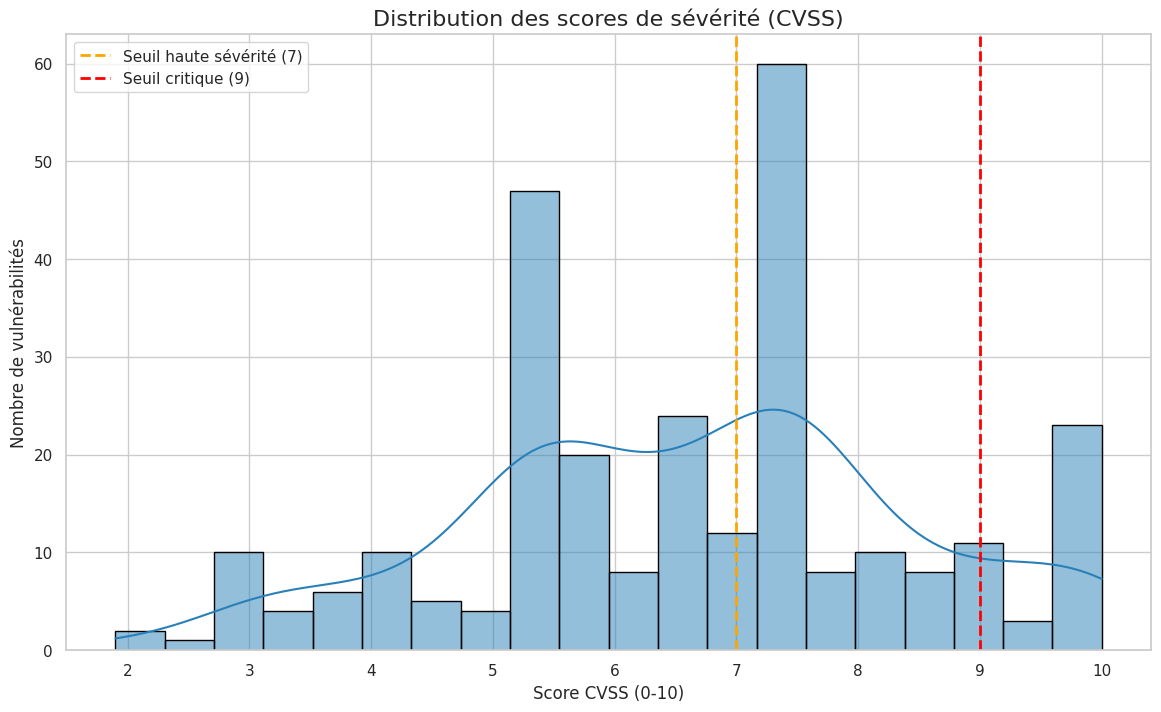

In [2]:
plt.figure()
sns.histplot(data=df, x='CVSS', bins=20, kde=True, color='#2980b9', edgecolor='black')

plt.axvline(x=7.0, color='orange', linestyle='--', linewidth=2, label='Seuil haute sévérité (7)')
plt.axvline(x=9.0, color='red', linestyle='--', linewidth=2, label='Seuil critique (9)')

plt.title('Distribution des scores de sévérité (CVSS)')
plt.xlabel('Score CVSS (0-10)')
plt.ylabel('Nombre de vulnérabilités')
plt.legend()
plt.show()

D'après ce graphique, nous constatons que les vulnérabilités détectées ont majoritairement un score CVSS compris entre 5 et 8, ce qui correspond à une gravité moyenne à très élevée. Les vulnérabiltés considérées comme critiques (avec un score CVSS au dessus de 9) ne concernent que 40 vulnérabilités sur les 264 répertoriées. La grande majorité des vulnérabilités recensées ne seront donc pas considérées comme dangereuses mais la part de vulnérabiltés critiques est tout de même présente et à surveiller.

# Diagramme circulaire des types de vulnérabilités (CWE)

---



Identifier les familles de failles les plus fréquentes

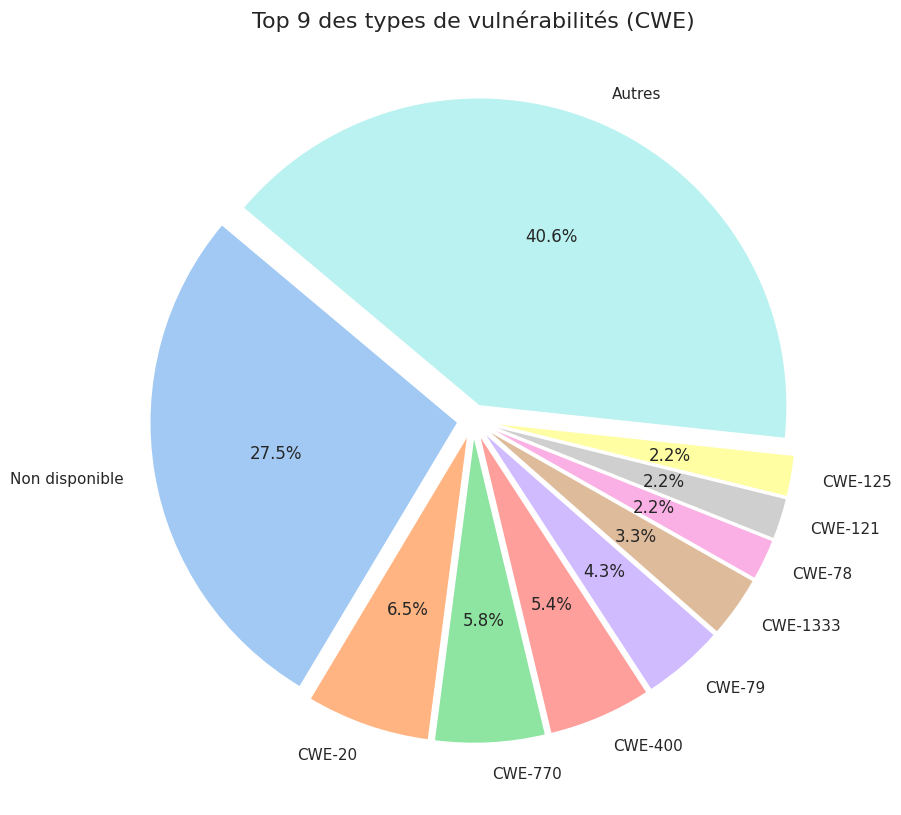

In [3]:
plt.figure(figsize=(10, 10))

# Top 10, le reste va dans Autres
top_n = 9
cwe_counts = df['CWE'].value_counts()
top_cwe = cwe_counts.head(top_n)
other_count = cwe_counts.iloc[top_n:].sum()
top_cwe['Autres'] = other_count

colors = sns.color_palette('pastel')[0:len(top_cwe)]

plt.pie(top_cwe, labels=top_cwe.index, autopct='%1.1f%%', startangle=140, colors=colors, explode=[0.05]*len(top_cwe))
plt.title(f'Top {top_n} des types de vulnérabilités (CWE)')
plt.show()

Il semblerait d'après ce graphique que la majorité (67.1%) des vulnérabilités ne soient pas couramment répertoriées ou soient inconnues. Ce graphique n'apporte donc pas réellement d'éléments dans l'analyse des alertes.

# Courbe de densité des scores EPSS

---



Visualiser la probabilité d'exploitation réelle des vulnérabilités

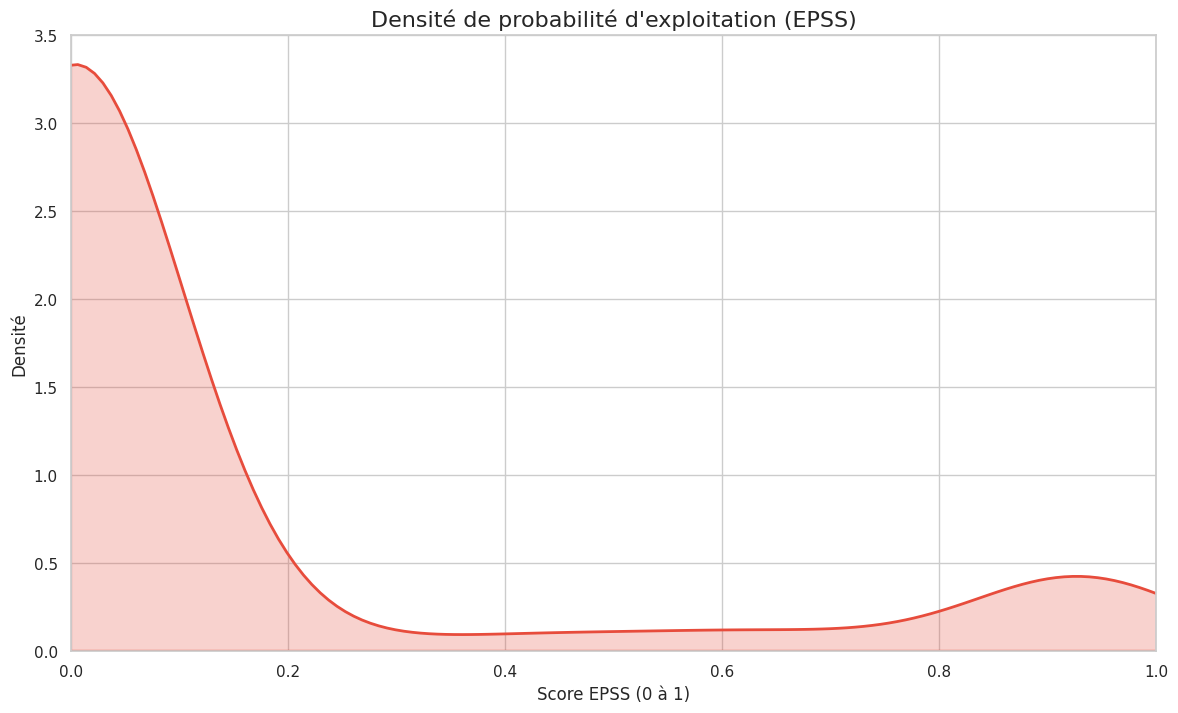

In [4]:
plt.figure()
# log car EPSS < 1
sns.kdeplot(data=df, x='EPSS', fill=True, color='#e74c3c', linewidth=2)

plt.title('Densité de probabilité d\'exploitation (EPSS)')
plt.xlabel('Score EPSS (0 à 1)')
plt.ylabel('Densité')
plt.xlim(0, 1)
plt.grid(axis='x', which='minor', linestyle=':', alpha=0.5)
plt.show()

La grande majorité des vulnérabiltés recensées obtiennent un score EPSS très faible (en-desous de 0.2), ce qui veut dire que la probabilité qu'elles soient exploitées est très faible. Les vulnérabilités qui ont une grande probabilité d'être exploitées ne dépassent pas une densité de 0.5 contre 3.4 pour celles ayant un score EPSS très faible. Ainsi, les vulnérabilités qui vont particulièrement nous intéresser dans ce projet sont celles possédant un score EPSS élevé (>0.9). Cela ne représentent qu'un petit nombre de vulnérabilités sur la totalité recensée.

# Classement des éditeurs (vendors) les plus affectés

---



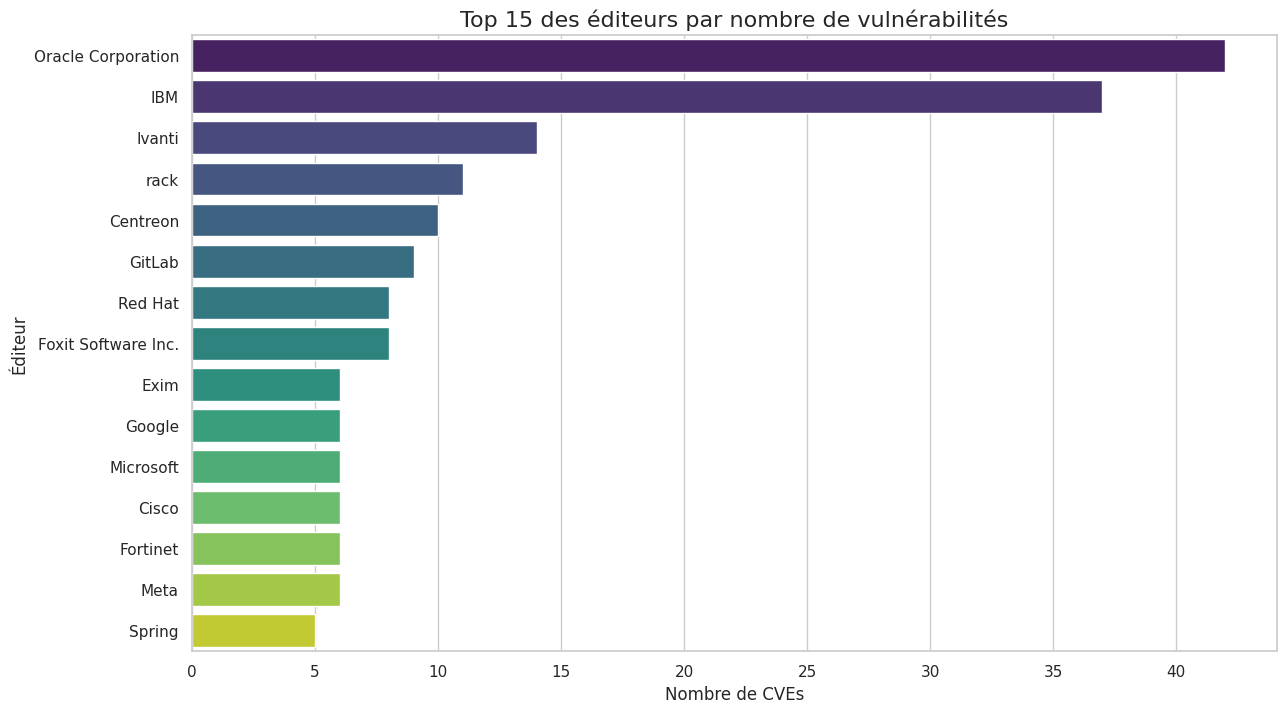

In [5]:
plt.figure()

# on enlève Inconnu et n/a
top_vendors = df[~df['Vendor'].isin(['Inconnu', 'n/a'])]['Vendor'].value_counts().head(15)

sns.barplot(x=top_vendors.values, y=top_vendors.index, hue=top_vendors.index, palette="viridis", legend=False)

plt.title('Top 15 des éditeurs par nombre de vulnérabilités')
plt.xlabel('Nombre de CVEs')
plt.ylabel('Éditeur')
plt.show()

Ce TOP15 des éditeurs les plus affectés par des vulnérabilités révèle que Oracle et IBM sont largement en tête de ce classement avec un nombre de CVEs publiées de 34 et 40 respectivement sur les 264 recensées. La conclusion donnée par ce graphique serait donc qu'Oracle et IBM fournissent les systèmes les plus vulnérables et sont donc les principaux éditeurs à surveiller pour transmettre les alertes. Toutefois, il est bien de noter que ces entreprises vendent des logiciels à installer sur un pc en local contrairement à Google (en position 7 dans ce classement) qui fournit des services hébergés sur ses propres serveurs. Ainsi, IBM et Oracle ont le devoir de publier chaque vulnérabilité pouvant toucher l'utilisateur, ce qui explique leur position dans ce classement.

# Heatmap des corrélations CVSS - EPSS

---



Analyser la relation entre la gravité théorique et le risque réel

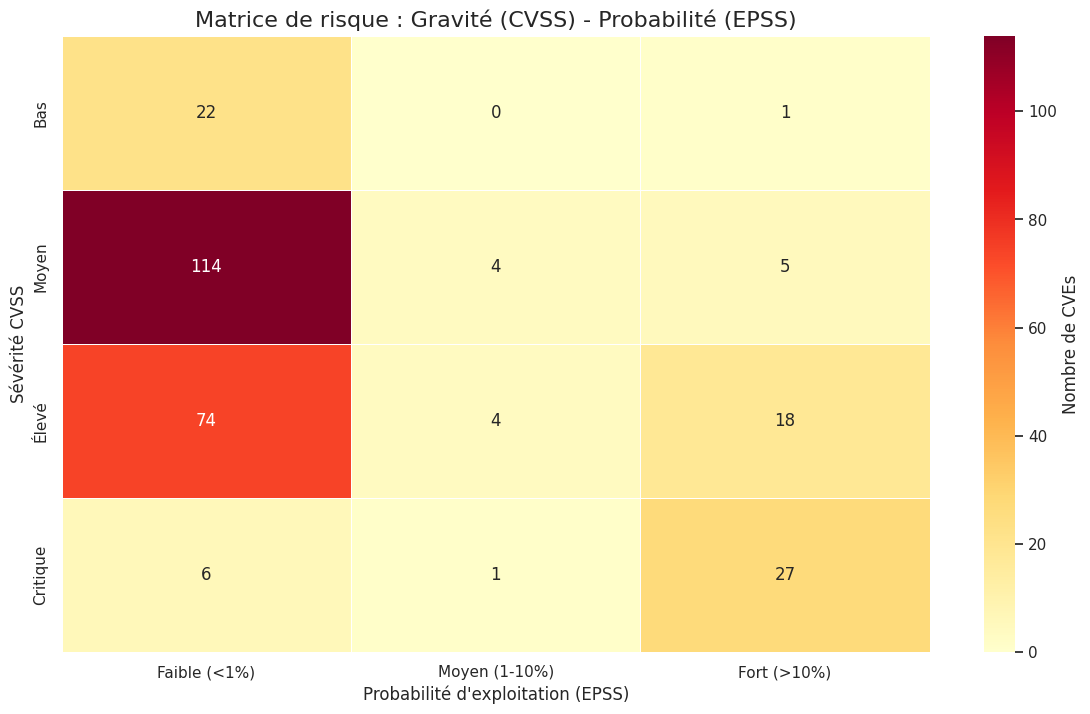

In [6]:
plt.figure()

df['CVSS_Bin'] = pd.cut(df['CVSS'], bins=[0, 3.9, 6.9, 8.9, 10], labels=['Bas', 'Moyen', 'Élevé', 'Critique'])
df['EPSS_Bin'] = pd.cut(df['EPSS'], bins=[0, 0.01, 0.1, 1.0], labels=['Faible (<1%)', 'Moyen (1-10%)', 'Fort (>10%)'])

pivot_table = df.groupby(['CVSS_Bin', 'EPSS_Bin'], observed=False).size().unstack(fill_value=0)

sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd', linewidths=.5, cbar_kws={'label': 'Nombre de CVEs'})
plt.title('Matrice de risque : Gravité (CVSS) - Probabilité (EPSS)')
plt.ylabel('Sévérité CVSS')
plt.xlabel('Probabilité d\'exploitation (EPSS)')
plt.show()

Cette heatmap des corrélations entre score CVSS et EPSS montre dans un premier temps que la majorité des CVEs obtiennent une sévérité moyenne à élevée, ce qui représente 183 des vulnérabilités sur les 264 étudiées. Dans un second temps, nous observons donc que cette majorité possède une probabilité très faible d'exploitation car inférieure à 1% (score EPSS). Le nombre de CVEs ayant une probabilité élevée d'être exploitée (>10%) concerne 51 CVEs sur les 264 au total dont 27 obtiennent une sévérité critique sur un total de 29 vulnérabilités critiques. Ainsi, les CVEs ayant la plus grande probabilité d'être exploitées ont majoritairement une sévérité "Critique" ou "élevé" et sont donc celles qui seront à surveiller en prioriter afin de transmettre l'alerte aux utilisateurs concernés.

# Nuage de points CVSS - EPSS

---



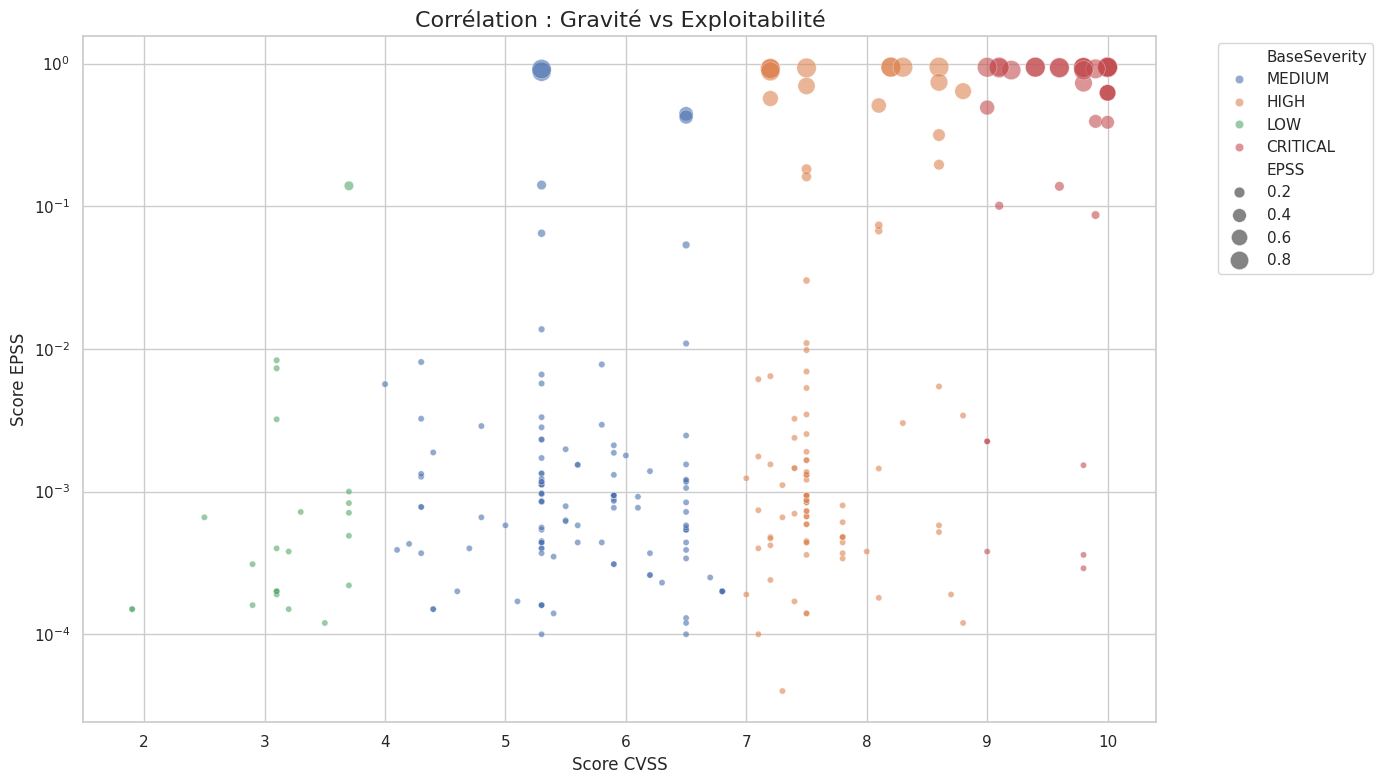

In [7]:
plt.figure()

sns.scatterplot(
    data=df,
    x='CVSS',
    y='EPSS',
    hue='BaseSeverity',
    palette='deep',
    size='EPSS',
    sizes=(20, 200),
    alpha=0.6
)

plt.title('Corrélation : Gravité vs Exploitabilité')
plt.yscale('log')
plt.ylabel('Score EPSS')
plt.xlabel('Score CVSS')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Nous observons sur ce graphique la corrélation entre la gravité de la vulnérabilité et la probabilité qu'elle soit exploitée. Ainsi, plus la corrélation (le point sur le graphique) est élevée (est gros), plus nous devons porter une attention particulière à ce type de vulnérabilité. Nous observons donc que la majorité des corrélations ont un score très faible (<0.2), ce qui correspond à des vulnérabilités qui ont une probabilité d'être exploitée très faible. Toutefois, nous observons que les corrélations ayant un score élevé (>0.6) se situent dans l'angle supérieur droit de ce graphique et concerne donc les vulnérabilités ayant un score EPSS proche de 1 et un score CVSS compris entre 7 et 10. Ces vulnérabilités fortement corrélées ont majoritairement une sévérité "élevée" à "critique" (et parfois "moyenne"). Ainsi dans le cadre de ce projet, nous pourrons nous concentrer sur les vulnérabilités considérées comme élévées ou critiques puisqu'il semblerait que celles-ci ont la plus grande probabilité qu'elles soient exploitées.

# Courbe cumulative des vulnérabilités dans le temps

---



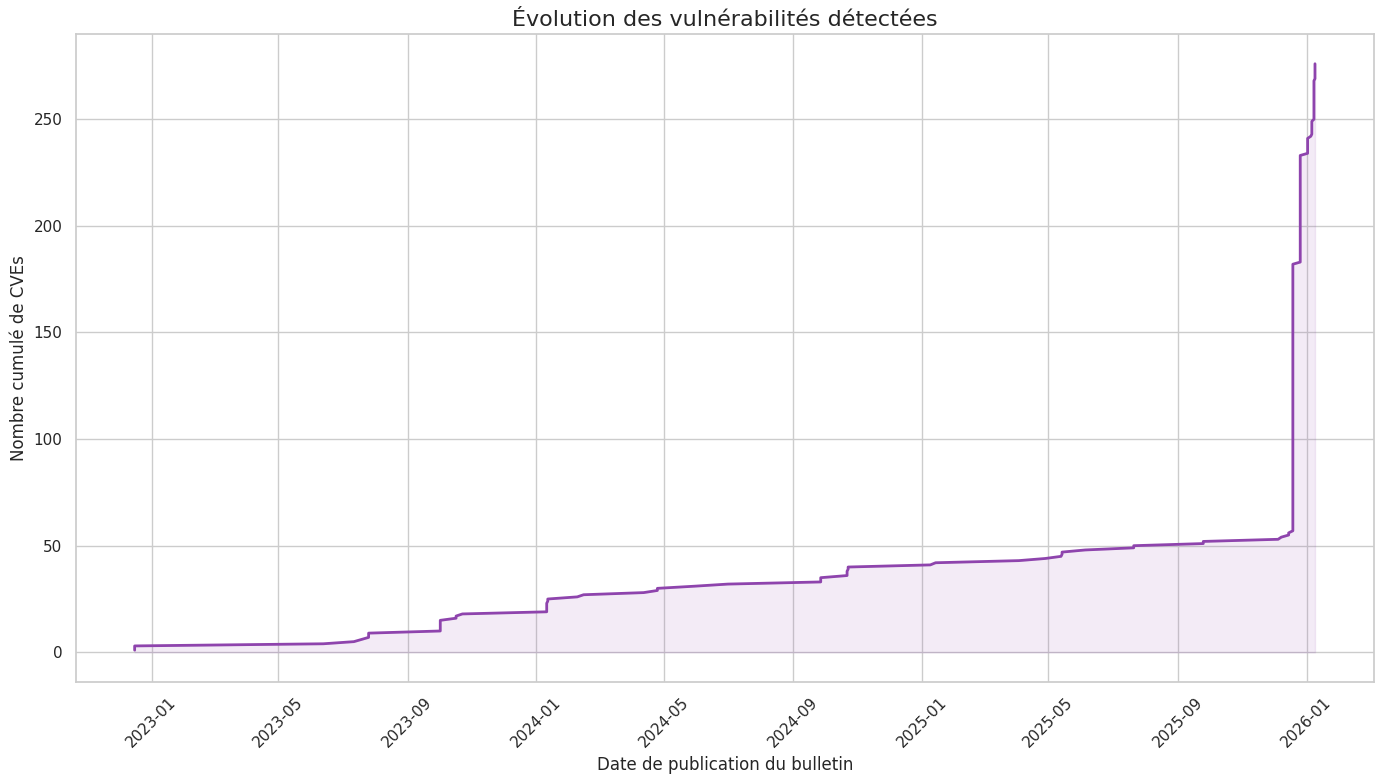

In [8]:
plt.figure()

# Tri par date
df_sorted = df.sort_values('Date').dropna(subset=['Date'])
df_sorted['Cumul'] = range(1, len(df_sorted) + 1)

plt.plot(df_sorted['Date'], df_sorted['Cumul'], color='#8e44ad', linewidth=2)
plt.fill_between(df_sorted['Date'], df_sorted['Cumul'], color='#8e44ad', alpha=0.1)

plt.title('Évolution des vulnérabilités détectées')
plt.xlabel('Date de publication du bulletin')
plt.ylabel('Nombre cumulé de CVEs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ce graphique présente l'évolution du nombre de CVEs entre janvier 2023 et janvier 2026. Nous observons que de nombreuses CVEs sont repertoriées chaque mois avec une forte hausse en décembre 2025 (+145) pour atteindre un total de 225 CVEs en janvier 2026. La majorité des vulnérabilités ont donc été enregistrées en décembre 2025 (+195) pour un total de 225 en 3 ans. Etant donné ces récentes recrudescences de vulnérabilités, nous devons nous maintenir en alerte pendant les mois à venir et prévenir rapidement de l'apparition de nouvelles vulnérabilités afin que des mesures soient prises.

# Boxplot des scores CVSS par éditeur

---



Montrer la dispersion de la gravité pour les top éditeurs

/tmp/ipython-input-62962493.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='Vendor', y='CVSS', palette="Set3")


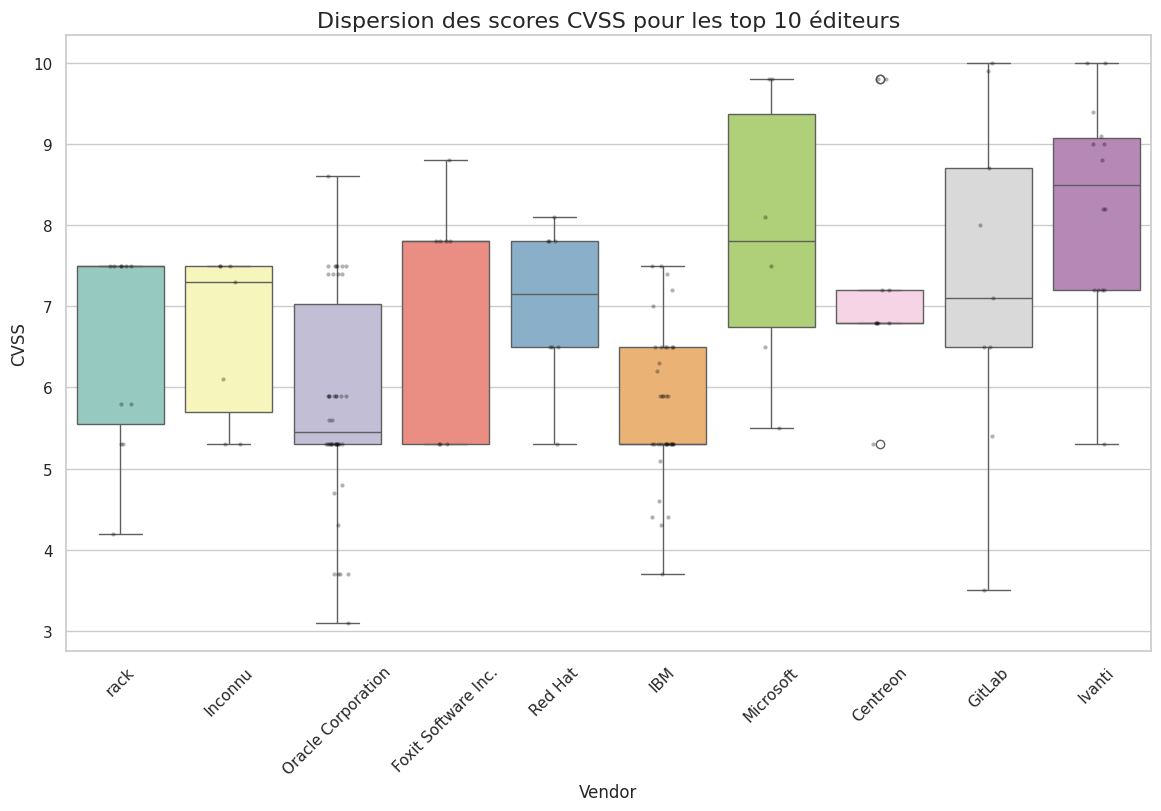

In [9]:
plt.figure()

top_10_vendors = df['Vendor'].value_counts().head(10).index
df_filtered = df[df['Vendor'].isin(top_10_vendors)]

sns.boxplot(data=df_filtered, x='Vendor', y='CVSS', palette="Set3")
sns.stripplot(data=df_filtered, x='Vendor', y='CVSS', color='black', alpha=0.3, size=3)

plt.title('Dispersion des scores CVSS pour les top 10 éditeurs')
plt.xticks(rotation=45)
plt.show()

Ce graphique représente la dispersion du score CVSS pour le TOP10 des éditeurs. Nous observons que tous les éditeurs ont déjà fait face à une vulnérabilité avec un score de gravité supérieur à 7 (élevé) mais que pour 7 éditeurs sur 10, la majorité des vulnérabilités ont un score CVSS compris entre 5 et 8 (modéré à élevé). Seuls trois éditeurs présentent des données qui sortent du lot, il s'agit de Cisco, Meta et Ivanti qui n'ont principalement que des vulnérabilités ayant un score élevé. Pour ces trois éditeurs, la majorité des vulnérabilités sont considérés comme très élevées à critiques avec certaines vulnérabilités atteignant un score CVSS de 10 (score le plus élevé). Ainsi, il semblerait que Cisco et Meta (Ivanti secondairement) soient des éditeurs à surveiller car comme vu précédemment, les vulnérabilités les plus susceptibles d'être exploitées sont les vulnérabilités très élevées à critiques (avec un score CVSS supérieur à 7), ce qui concerne particulièrement Cisco et Meta.

# Versions les plus affectées

---



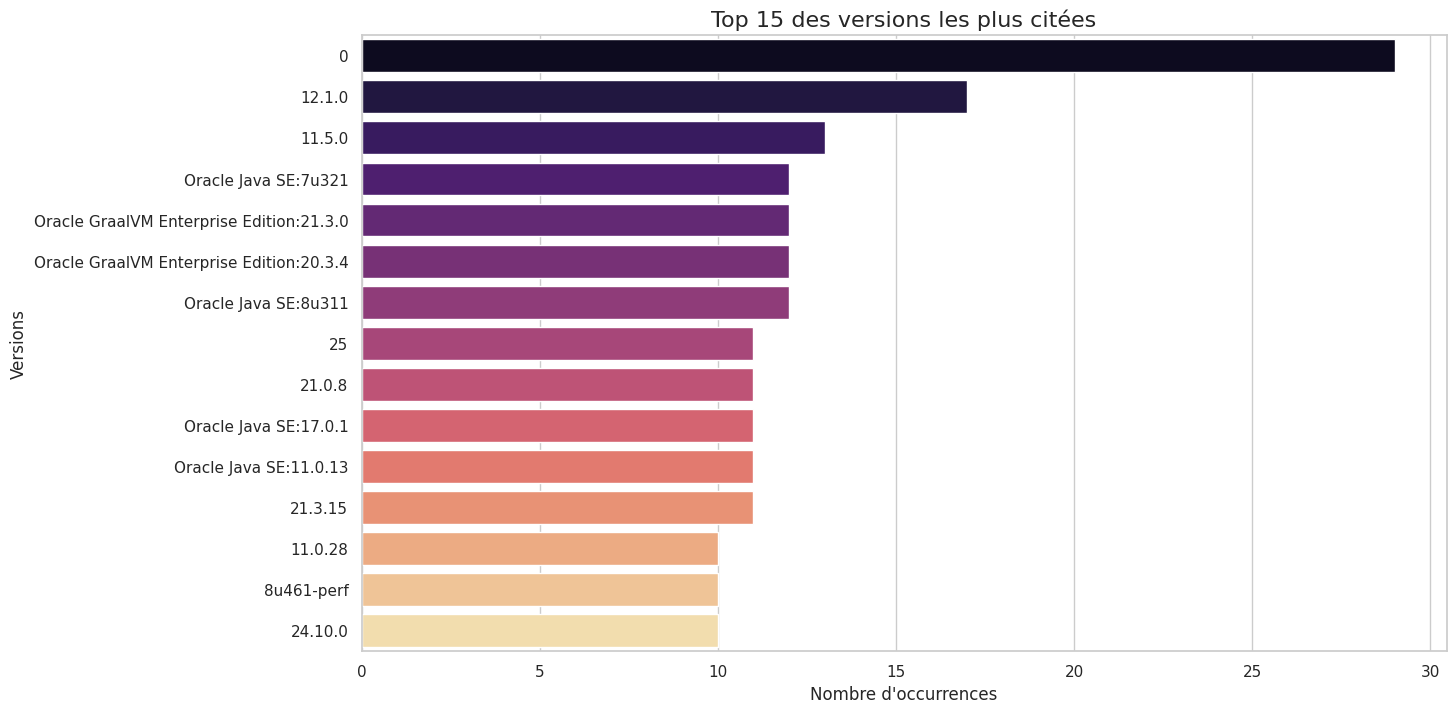

In [10]:
plt.figure()

# Nettoyage et séparation des versions
versions_series = df['Versions'].dropna().astype(str).str.split(', ').explode()
versions_clean = versions_series[~versions_series.isin(['n/a', 'unspecified', 'Non spécifié'])]

top_versions = versions_clean.value_counts().head(15)

sns.barplot(x=top_versions.values, y=top_versions.index, hue=top_versions.index, palette="magma", legend=False)
plt.title('Top 15 des versions les plus citées')
plt.xlabel('Nombre d\'occurrences')
plt.show()

Ce graphique met en avant les 15 versions de produits les plus sensibles aux vulnérabilités. La version 0 sort particulièrement du lot avec plus de 28 occurences contre 8 à 17 pour les autres versions. Ainsi, la version 0 est en priorité à surveiller pour la détection de vulnérabilités.

# Niveaux de Sévérité par Éditeur

---



/tmp/ipython-input-1304777908.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sev['BaseSeverity'] = pd.Categorical(df_sev['BaseSeverity'], categories=severity_order, ordered=True)


<Figure size 1400x800 with 0 Axes>

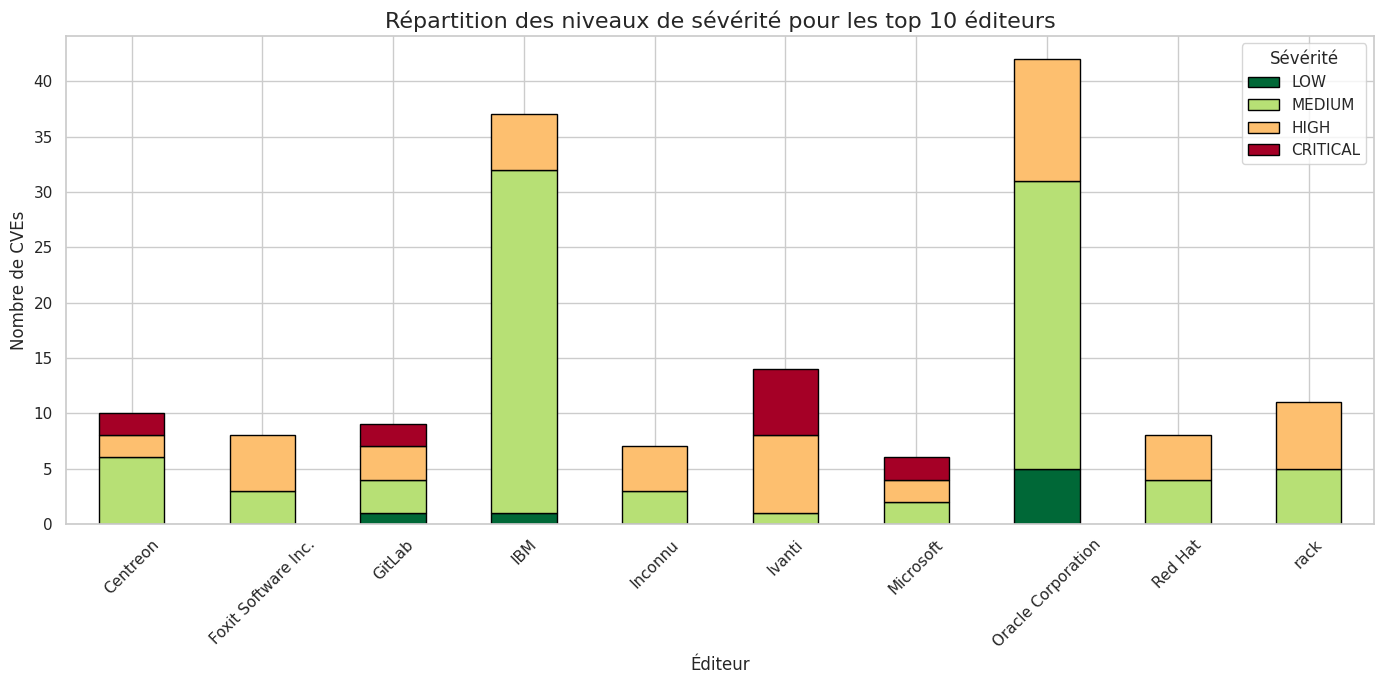

In [11]:
plt.figure()

top_vendors_sev = df['Vendor'].value_counts().head(10).index
df_sev = df[df['Vendor'].isin(top_vendors_sev)]

df_sev['BaseSeverity'] = pd.Categorical(df_sev['BaseSeverity'], categories=severity_order, ordered=True)

ct_sev = pd.crosstab(df_sev['Vendor'], df_sev['BaseSeverity'])
ct_sev.plot(kind='bar', stacked=True, colormap='RdYlGn_r', figsize=(14, 7), edgecolor='black')

plt.title('Répartition des niveaux de sévérité pour les top 10 éditeurs')
plt.xlabel('Éditeur')
plt.ylabel('Nombre de CVEs')
plt.legend(title='Sévérité')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ce graphique présente la répartition des niveaux de sévérité pour le TOP10 des éditeurs. Nous pouvons observer que seuls trois d'entre eux (Cisco, Ivanti et Meta) ont recensé des vulnérabilités critiques mais que toutes ont déja recensé des vulnérabilités de sévérité élevée. De plus, deux éditeurs semblent sortir du lot quand au nombre de CVEs recensées, il s'agit d'IBM et Oracle comme vu dans de précédents graphiques avec un nombre compris entre 30 et 40. Ainsi, Ivanti, Meta et Cisco semble être particulièrement à surveiller (comme vu dans de précédents graphiques).

# Distribution EPSS par sévérité

---



Les failles critiques sont-elles vraiment plus exploitées ?

/tmp/ipython-input-1433418327.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_violin, x='BaseSeverity', y='EPSS', order=severity_order, palette='muted')


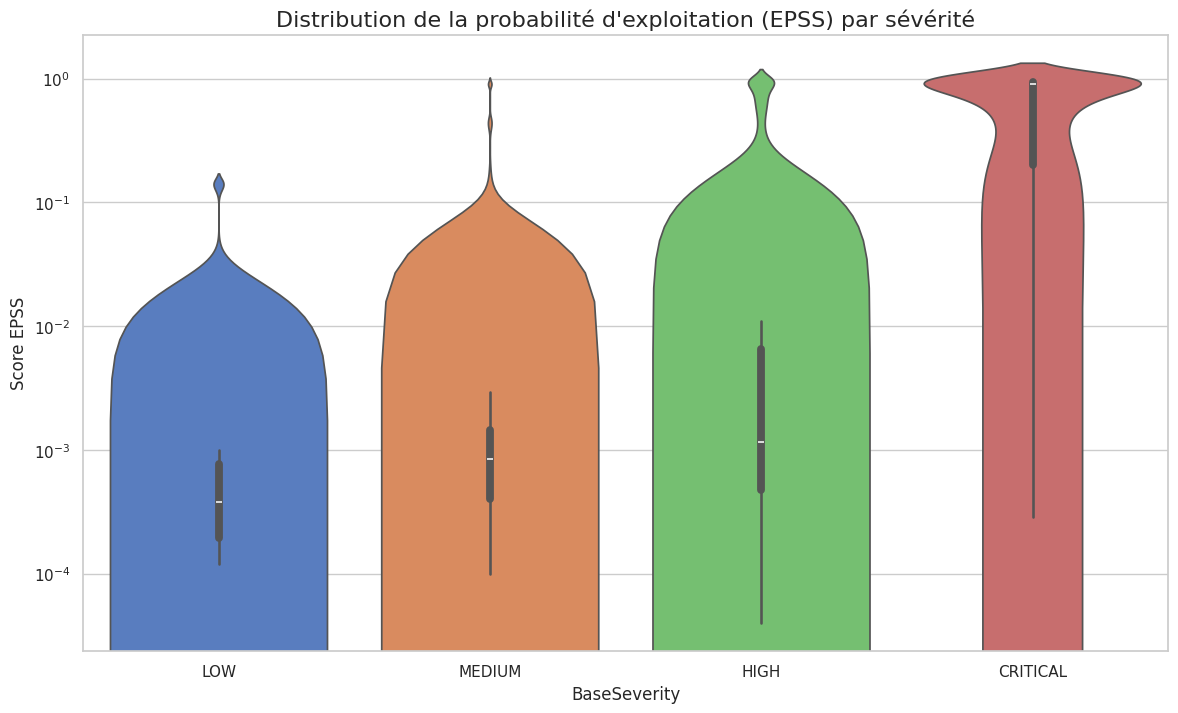

In [12]:
plt.figure()

df_violin = df[df['BaseSeverity'].isin(severity_order)]

sns.violinplot(data=df_violin, x='BaseSeverity', y='EPSS', order=severity_order, palette='muted')

plt.title('Distribution de la probabilité d\'exploitation (EPSS) par sévérité')
plt.yscale('log')
plt.ylabel('Score EPSS')
plt.show()

Ce graphique présente la distribution de la probabilité d'exploitation en fonction du score EPSS. La distribution pour les sévérités LOW, MEDIUM et HIGH sont très similaire avec une forte concentration pour un score EPSS compris entre 10**(-4) et 10**(-1). Toutefois, nous pouvons remarquer que la distribution pour une sévérité critique est très différente puisque la concentration se situe majoritairement entre 10**(-1) et 1. Ainsi, ce sont les vulnérabilités critiques qui possèdent bien la plus grande probabilité d'exploitation et seront donc notre point de vigilance dans notre dispositif d'alerte.

# Évolution de la sévérité moyenne dans le temps

---



Est-ce que les vulnérabilités découvertes deviennent de plus en plus graves au fil des mois ?

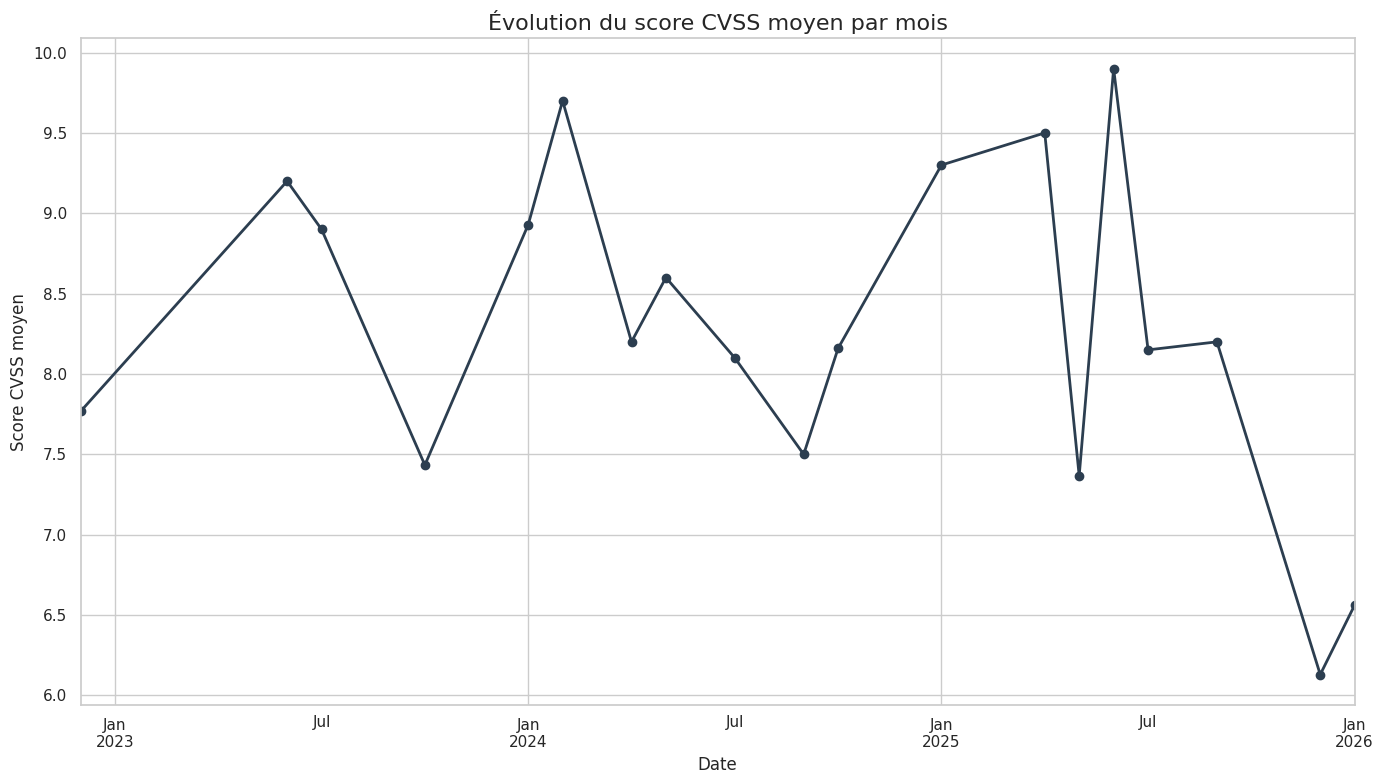

In [13]:
plt.figure()

severity_trend = df.groupby('Month_Year')['CVSS'].mean()

severity_trend.plot(marker='o', linestyle='-', color='#2c3e50', linewidth=2)
plt.title('Évolution du score CVSS moyen par mois')
plt.xlabel('Date')
plt.ylabel('Score CVSS moyen')
plt.grid(True)
plt.tight_layout()
plt.show()

Ce graphique montre l'évolution du score CVSS moyen par mois entre fin 2022 et janvier 2026. Nous pouvons observer que le score CVSS moyen se situe en grande partie entre 7.5 (élevé) et 10 (critique). Toutefois, nous observons également une chute brutal du score CVSS à partir de juin 2025 passant de 9.9 (très critique) à 6 (moyen) en janvier 2026. Cette baisse présage une montée en puissance du score CVSS moyen dans les prochains mois et requiert donc notre plus grande vigilance.

# Volume vs Sévérité

---



Positionne les éditeurs selon le volume de failles et leur gravité moyenne

Haut-Droit : éditeurs avec beaucoup de failles qui sont très graves
Bas-Gauche : éditeurs avec peu de failles qui sont peu graves

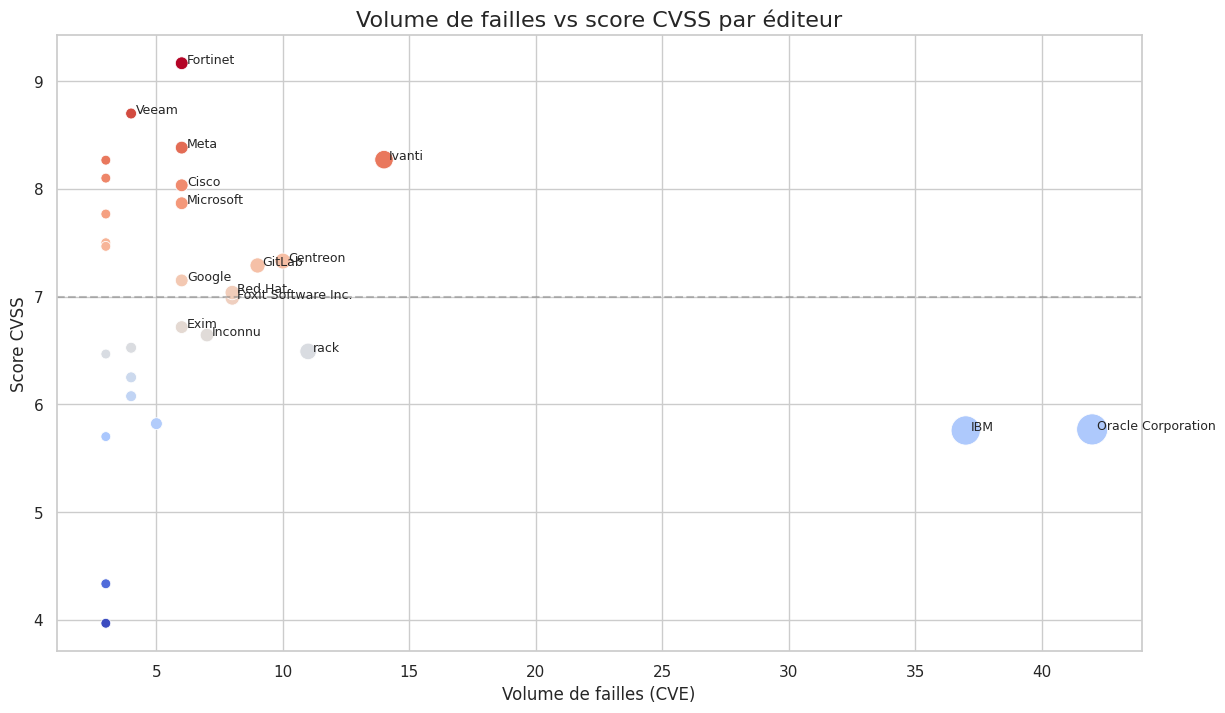

In [14]:
plt.figure()

vendor_stats = df.groupby('Vendor').agg({
    'CVSS': 'mean',
    'CVE_ID': 'count'
}).reset_index()

# Filtre pour garder les éditeurs significatifs (> 2 CVE)
vendor_stats = vendor_stats[vendor_stats['CVE_ID'] > 2]

sns.scatterplot(
    data=vendor_stats,
    x='CVE_ID',
    y='CVSS',
    size='CVE_ID',
    sizes=(50, 500),
    hue='CVSS',
    palette='coolwarm',
    legend=False
)

for i in range(vendor_stats.shape[0]):
    if vendor_stats.CVE_ID.iloc[i] > 5 or vendor_stats.CVSS.iloc[i] > 8.5:
        plt.text(
            vendor_stats.CVE_ID.iloc[i]+0.2,
            vendor_stats.CVSS.iloc[i],
            vendor_stats.Vendor.iloc[i],
            fontsize=9
        )

plt.title('Volume de failles vs score CVSS par éditeur')
plt.xlabel('Volume de failles (CVE)')
plt.ylabel('Score CVSS')
plt.axhline(y=7, color='grey', linestyle='--', alpha=0.5)
plt.show()

Ce graphique présente le volume de failles en fonction du score CVSS en fonction des éditeurs. Nous pouvons observer que la majorité des éditeurs se situent sur la partie gauche du graphique ce qui signifie qu'ils ne recensent que peu de failles. Toutefois, nous retrouvons IBM et Oracle dans la partie droite étant donné le nombre important de failles qu'il recensent. En ce qui concerne la sévérité de la faille, une portion assez importante d'éditeurs se situent au dessus de la limite de 7 (élevé) avec Fortinet dépassant un score CVSS de 9 (critique). Ainsi, ce graphique nous montre que beaucoup d'éditeurs recensent peu de failles avec une sévérité faible mais qu'un nombre assez important d'éditeurs recensent peu de failles mais avec une sévérité élevée. Il est également bien de noter qu'aucun éditeur ne se trouve dans la partie haute et droite du graphique qui correspond au recensemment de beaucoup de vulnérabilités avec une grande sévérité. Ainsi, les vulnérabilités élevées semblent courantes et recensées par de nombreux éditeurs (où nous retrouvons Meta, Ivanti et Cisco) mais ne nous permet pas de nous concentrer uniquement sur une poignée d'éditeurs.

# Heatmap jour de la semaine vs Type

---



Quand est-ce que l'ANSSI publie-t-elle le plus ?
Utile pour organiser les équipes de veille

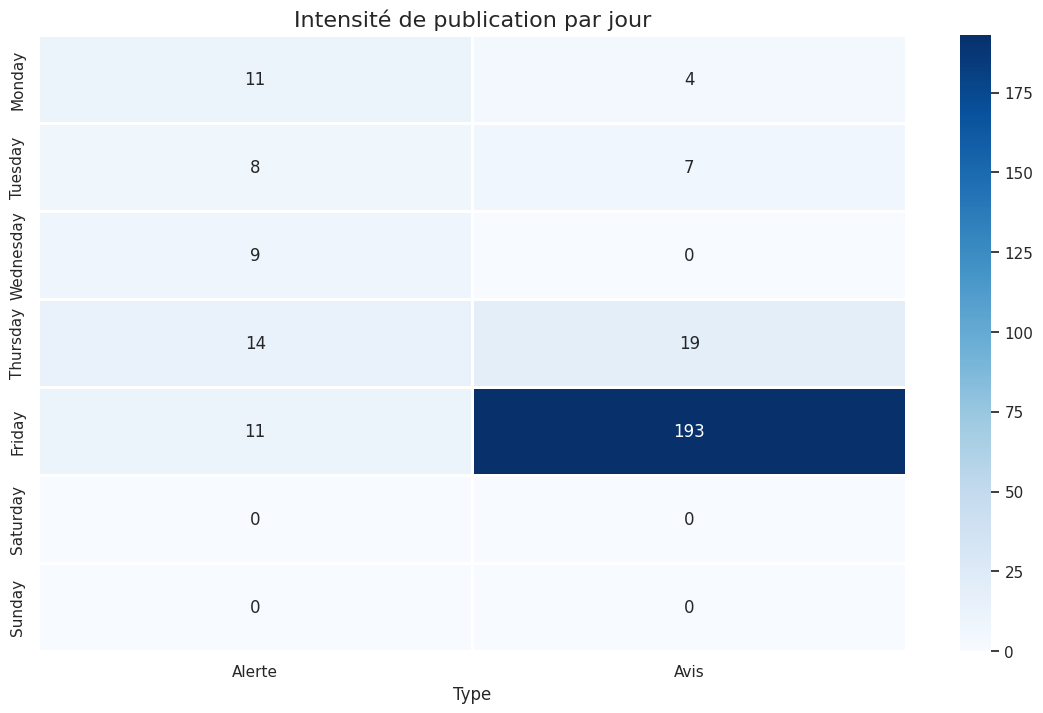

In [15]:
plt.figure()

df['DayOfWeek'] = df['Date'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


time_heatmap = pd.crosstab(df['DayOfWeek'], df['Type'])

# remplace NaN par 0
time_heatmap = time_heatmap.reindex(days_order).fillna(0).astype(int)

sns.heatmap(time_heatmap, annot=True, cmap='Blues', fmt='d', linewidths=1)
plt.title('Intensité de publication par jour')
plt.ylabel('')
plt.show()

Ce graphique présente les intensités de publication des vulnérabilités en fonction des jours de la semaine. Nous remarquons directement que le vendredi est le jour où le plus de vulnérabilités sont recensées avec 199 avis et 11 alertes sur 211 avis et 53 alertes. La répartitions des alertes sur la semaine est toutefois un peu plus large puisque du lundi au vendredi nous observons entre 8 et 14 publications. Il est également à noter que le samedi et le dimanche ne recensent aucunes vulnérabilités, probablement car personne ne travaille ce jour là.

# Top 20 des vulnérabilités prioritaires - CVSS et EPSS élevés

---



Liste les failles graves et exploitables

/tmp/ipython-input-1505684612.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_risks, x='EPSS', y='Label', palette='Reds_r')


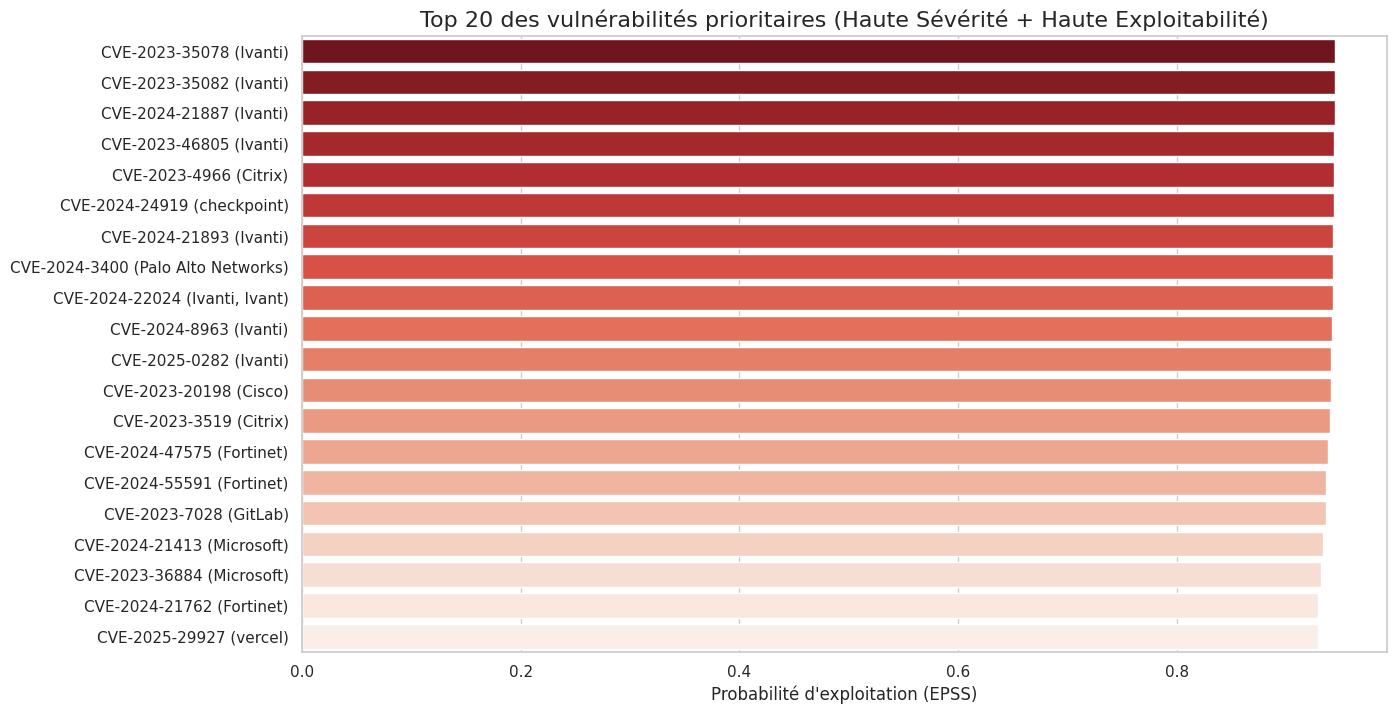

In [16]:
plt.figure()

# CVSS > 7 et EPSS > 0.01
critical_exploitable = df[(df['CVSS'] >= 7.0) & (df['EPSS'] >= 0.01)].copy()

top_risks = critical_exploitable.sort_values('EPSS', ascending=False).head(20)

top_risks['Label'] = top_risks['CVE_ID'] + ' (' + top_risks['Vendor'] + ')'

sns.barplot(data=top_risks, x='EPSS', y='Label', palette='Reds_r')
plt.title('Top 20 des vulnérabilités prioritaires (Haute Sévérité + Haute Exploitabilité)')
plt.xlabel('Probabilité d\'exploitation (EPSS)')
plt.ylabel('')
plt.show()

Ce dernier graphique est très intéressant du point de vu du projet car il présente le TOP20 des vulnérabilités prioritaires (c'est-à-dire avec une haute sévérité et une haute exploitabilité). Nous remarquons tout d'abord qu'Ivanti prend les quatre premières places de ce TOP et revient régulièrement dans ce TOP20 avec 8 occurences concernant des CVEs différentes. D'autres éditeurs tels que Fortinet et Microsoft apparaissent également plusieurs fois. Toutefois, il semblerait qu'Ivanti soit principalement l'éditeur que nous devrions surveiller avec la plus grande vigilance. Cet éditeur semble être le plus vulnérable et notre réactivité pourrait permettre de protéger au mieux les utilisateurs de leurs produits.